### Importing required pakages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import Counter


In [2]:
import os
os.getcwd()

'D:\\Abhishek\\Personal\\Springboard\\Springboard_DSC\\Capstone Projects'

### Importing Data from the CSV file
Missing values in the file are represented by '?'. 

In [3]:
%%time
#load original data into dataframe
file ='D:\\Abhishek\\Personal\\Springboard\\dataset_diabetes\\diabetic_data.csv'
df1 = pd.read_csv(file, na_values = '?')

Wall time: 567 ms


<string>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


### Understanding the Data. 
Number of columns, whether it was imported correctly, number of missing values etc.

In [4]:
#check shape of the dataset and its columns
df1.info()
df1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non

(101766, 50)

In [5]:
#Checking if the data was imported correctly
df1.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
len(df1['weight'].unique())
df1.race.mode()[0]

'Caucasian'

Converting the objects to categories. This would help save memory space.

## Missing Value Analysis

### Finding our features with missing value

In [7]:
# Creating a empty table to store Missing Values Count
m_table = pd.DataFrame(columns = ['feature_name', 'null_values', '%missing', 'category_count'])

#Counting the missing values and appending it to m_table
for col in df1.columns:
    null_value = len(df1) - df1[col].count()
    missing = round((null_value/len(df1))*100,2)
    count = len(df1[col].unique())
    m_table = m_table.append(pd.Series([col, null_value, missing,count],index = m_table.columns),ignore_index=True)

#Displaying features which has missing values in descending order
missing = m_table[m_table.null_values != 0].sort_values(by = '%missing',ascending = False).reset_index(drop = True)
display('Missing Value Table')
display(missing)
print('\n')

#Displaying features having only single category
c_count = m_table[m_table.category_count == 1].sort_values(by = '%missing',ascending = False).reset_index(drop = True)
display('Single Category Features')
display(c_count)

'Missing Value Table'

,feature_name,null_values,%missing,category_count
0,weight,98569,96.86,10
1,medical_specialty,49949,49.08,73
2,payer_code,40256,39.56,18
3,race,2273,2.23,6
4,diag_3,1423,1.40,790
5,diag_2,358,0.35,749
6,diag_1,21,0.02,717


'Single Category Features'

,feature_name,null_values,%missing,category_count
0,examide,0,0.0,1
1,citoglipton,0,0.0,1


#### 6 features have missing values.
1) Weight have ~97% missing values. There is poor interpretability of the missing values, so it is best to drop this column. 

2) medical_speciality and payer_code have 40-50% missing values. I have decided to drop it but there are ways to deal with it. I will experiment and use this columns to see if it increases the accuracy of the model. Method to include these columns would be to create a separate category of 'missing'. 

3) race, diag_3, diag_2, diag_1  have only <=2% missing values, so missing rows can be dropped or be replace with mode of the column values. 

5) When all diag are missing, then also it is a bad data. So secondly, removing all rows where where all 3 diag are missing

6) A missing first diagnosis while data have diagnosis second and third, is also a bad data. But second and third diagnosis can give us some idea about the readmission. So we  can either keep this missing values under "missing" category or just ignore the rows. I am going with first one.  

7) For the remaining missing values of Race, it is repalced by mode i.e. Caucasian. 

8) In gender, there are values like "Unknown/Invalid" which are missing. These columns are also dropped




In [8]:
# Droping weight, medical_speciality and payer_code
drop_col1 = ['weight', 'medical_specialty','payer_code']
df_clean =df1.drop(drop_col1,axis = 1)

# Droping rows with missing values in all 4 columns of race, diag_3, diag_2 and diag_1
drop_col2 = ['diag_1','diag_2', 'diag_3']
df_clean = df_clean.dropna(subset = drop_col2, how = 'all')

# Replacing missing values of 'diag_1, diag_2, diag_3' with Missing = 'M'
values = {'diag_1': '0', 'diag_2': '0', 'diag_3': '0'}
df_clean = df_clean.fillna(value = values)

# Droping rows with gender value  as 'Unknown/Invalid'
df_clean = df_clean[df_clean.gender != 'Unknown/Invalid']

# Replacing missing values of 'race' with mode 
df_clean = df_clean.fillna(value={'race': df1.race.mode()[0]})

#df_clean.info()
df_clean.shape

(101762, 47)

Following code will see if there are any more missing values or not

In [9]:
# Creating a empty table to store Missing Values Count
c_table = pd.DataFrame(columns = ['feature_name', 'null_values', '%missing', 'category_count'])

#Counting the missing values and appending it to m_table
for col in df_clean.columns:
    null_value = len(df_clean) - df_clean[col].count()
    missing = round((null_value/len(df_clean))*100,2)
    count = len(df_clean[col].unique())
    c_table = c_table.append(pd.Series([col, null_value, missing,count],index = c_table.columns),ignore_index=True)

#Displaying features which has missing values in descending order
display('Missing Value Table')
display(c_table)
print('\n')

'Missing Value Table'

,feature_name,null_values,%missing,category_count
0,encounter_id,0,0.0,101762
1,patient_nbr,0,0.0,71514
2,race,0,0.0,5
3,gender,0,0.0,2
4,age,0,0.0,10
5,admission_type_id,0,0.0,8
6,discharge_disposition_id,0,0.0,26
7,admission_source_id,0,0.0,17
8,time_in_hospital,0,0.0,14
9,num_lab_procedures,0,0.0,118


## Further Cleaning the Data

Since we are trying to predict readmissions, those patients who died during this hospital admission, have zero probability of readmission. So we should remove those records (discharge_disposition = 11, 19,20,21).

In [10]:
# List of Dicharge disposition ids saying that patient got expired or met with a death 
expired = [11,19,20,21]
df_clean = df_clean[~df_clean.discharge_disposition_id.isin(expired)]

While doing missing value analysis, I found that there are two columns where all records have same values (examide and citoglipton). So it would be better to drop these columns also since it cannot provide any information about readmission. 

In [11]:
# Dropping examide and citoglipton
no_info = ['examide','citoglipton']
df_clean = df_clean.drop(no_info,axis = 1)
df_clean.shape


(100110, 45)

Diagnosis columns have more than >600 categories. They are ICD9 Codes describing specific diseases. We can club them in larger categories in accordance with ICD9 to reduce the categories. 

In [12]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df_clean[col] = df_clean[col].str.replace('E','-')
    df_clean[col] = df_clean[col].str.replace('V','-')
    condition = df_clean[col].str.contains('250')
    df_clean.loc[condition,col] = '250'



In [13]:
df_clean[diag_cols] = df_clean[diag_cols].replace('',np.nan).astype(float)

# diagnosis grouping
for col in diag_cols:
    df_clean['temp']=np.nan
    
    condition = df_clean[col]==250
    df_clean.loc[condition,'temp']='Diabetes'
    
    condition = (df_clean[col]>=390) & (df_clean[col]<=458) | (df_clean[col]==785)
    df_clean.loc[condition,'temp']='Circulatory'
    
    condition = (df_clean[col]>=460) & (df_clean[col]<=519) | (df_clean[col]==786)
    df_clean.loc[condition,'temp']='Respiratory'
    
    condition = (df_clean[col]>=520) & (df_clean[col]<=579) | (df_clean[col]==787)
    df_clean.loc[condition,'temp']='Digestive'
    
    condition = (df_clean[col]>=580) & (df_clean[col]<=629) | (df_clean[col]==788)
    df_clean.loc[condition,'temp']='Genitourinary'
    
    condition = (df_clean[col]>=800) & (df_clean[col]<=999)
    df_clean.loc[condition,'temp']='Injury'
    
    condition = (df_clean[col]>=710) & (df_clean[col]<=739)
    df_clean.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df_clean[col]>=140) & (df_clean[col]<=239)
    df_clean.loc[condition,'temp']='Neoplasms'
    
    condition = df_clean[col] == 0
    df_clean.loc[condition,'temp']='Missing'
    df_clean['temp']=df_clean['temp'].fillna('Others')
    df_clean[col]=df_clean['temp']
    df_clean.drop('temp',axis=1,inplace=True)


In [14]:
df_clean.diag_1.value_counts()

Circulatory        29783
Others             17984
Respiratory        14074
Digestive           9380
Diabetes            8693
Injury              6879
Genitourinary       5054
Muscoloskeletal     4944
Neoplasms           3299
Missing               20
Name: diag_1, dtype: int64

#### For discharge disposition, admission type and admission source, ~90% of data falls under 3-4 categories. Thus we can club the remaining categories with the existing category or under others. This would help reduce the noise from the data. 

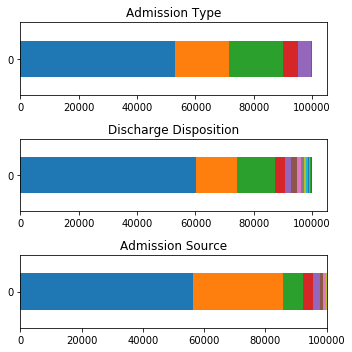

In [15]:
#Finding out the frequency for each category
adm = df_clean.groupby(['admission_type_id']).size().sort_values(ascending = False)
dis = df_clean.groupby(['discharge_disposition_id']).size().sort_values(ascending = False)
asrc = df_clean.groupby(['admission_source_id']).size().sort_values(ascending = False)

#Creating Subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 5))

pd.DataFrame(adm).T.plot.barh(stacked=True, ax = axes[0])
axes[0].legend().set_visible(False)
axes[0].title.set_text('Admission Type')
#plt.ylabel('Damped oscillation')

pd.DataFrame(dis).T.plot.barh(stacked=True, ax = axes[1])
axes[1].legend().set_visible(False)
axes[1].title.set_text('Discharge Disposition')

pd.DataFrame(asrc).T.plot.barh(stacked=True, ax = axes[2])
axes[2].legend().set_visible(False)
axes[2].title.set_text('Admission Source')

fig.tight_layout()

In [16]:
#removing warning
pd.options.mode.chained_assignment = None  # default='warn'

# 1: Discharge to Home
c1 = (df_clean.discharge_disposition_id == 1) | (df_clean.discharge_disposition_id == 13)|(df_clean.discharge_disposition_id == 14)

#18: Null Values
c2 = (df_clean.discharge_disposition_id == 18) | (df_clean.discharge_disposition_id == 25)

#remaining Values except 3, 6, in others: 29 as others
c3 = (df_clean.discharge_disposition_id != 1) & (df_clean.discharge_disposition_id != 3) & (df_clean.discharge_disposition_id != 6) & (df_clean.discharge_disposition_id != 18)

df_clean.discharge_disposition_id[c1] = 1
df_clean.discharge_disposition_id[c2] = 18
df_clean.discharge_disposition_id[c3] = 29

In [17]:
#Admission Type
#remaining Values except 1,2,3 in others: 4 as others
a1 = (df_clean.admission_type_id != 1) & (df_clean.admission_type_id != 2) & (df_clean.admission_type_id != 3)

df_clean.admission_type_id[a1] = 4

#Admission Source
# 9: Null values
c1 = (df_clean.admission_source_id == 9) | (df_clean.admission_source_id == 17)|(df_clean.admission_source_id == 20)

#remaining Values except 1, 7 in others: 26 as others
c2 = (df_clean.admission_source_id != 1) & (df_clean.admission_source_id != 7) & (df_clean.admission_source_id != 9)

df_clean.admission_source_id[c1] = 9
df_clean.admission_source_id[c2] = 26
df_clean.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),4,29,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### A patient has visited many times in the hospital. Re-admission rates migh also depend. So creating  a new feature for the number of times a patient has visited the hospital. Therafter dropping the encounter id and patient nbr columns

In [18]:
#Creating a dictionary of Patient and number of visits made by him/her
visit_p = dict(df_clean.groupby('patient_nbr').count()['encounter_id'].sort_values(ascending = False))

#Using the visit_p dictionary to map and create the new column of visit_num
df_clean['visit_num'] = df_clean.patient_nbr.map(visit_p)

#Dropping encounter_id and patient_nbr since they are mere ids
df_clean = df_clean.drop(['encounter_id','patient_nbr'], axis = 1)

Converting to categories to reduce memory space

In [19]:
#Selecting string columns
cat_names = list(df_clean.select_dtypes(include='object').columns)
cat_names_2 = ['admission_type_id','discharge_disposition_id','admission_source_id']
cat_names.extend(cat_names_2)

#Converting to categories
df_clean[cat_names] = df_clean[cat_names].astype('category')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100110 entries, 0 to 101765
Data columns (total 44 columns):
race                        100110 non-null category
gender                      100110 non-null category
age                         100110 non-null category
admission_type_id           100110 non-null category
discharge_disposition_id    100110 non-null category
admission_source_id         100110 non-null category
time_in_hospital            100110 non-null int64
num_lab_procedures          100110 non-null int64
num_procedures              100110 non-null int64
num_medications             100110 non-null int64
number_outpatient           100110 non-null int64
number_emergency            100110 non-null int64
number_inpatient            100110 non-null int64
diag_1                      100110 non-null category
diag_2                      100110 non-null category
diag_3                      100110 non-null category
number_diagnoses            100110 non-null int64
max_glu_seru

### Exploratory Data Analysis

In [21]:
medicines = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide',
             'tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','insulin',
             'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
             'metformin-pioglitazone','readmitted']
df_med = df_clean[medicines]


#### Checking the Distribution of Race for <30 category of Readmission. There seems to be three distinct groups. 

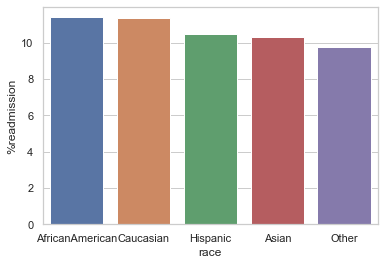

In [60]:
#Setting the Seaborn Graph Style
sns.set(style="whitegrid")

#Grouping Race and Readmitted.
race = df_clean.groupby(['race','readmitted']).size().unstack()

#Renaming the column index from category to string
race = race.rename(columns=str).reset_index()

#Calculating %Readmission
race['total'] = race['<30']+race['>30']+race['NO']
race['% total'] = 100* (race['total']/(race['total'].sum()))
race['%readmission'] = 100* (race['<30']/race['total'])
race.sort_values('%readmission',ascending = False, inplace = True)

#Plotting the bar Graph
sns.barplot(data = race, x = 'race',y='%readmission', order = race['race'])

#### Distribution of Age for <30 category of Readmission. Patient with >40 age have high chances of getting readmitted.

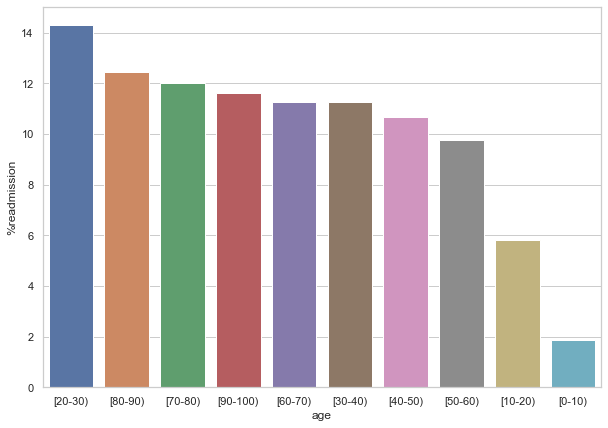

In [61]:
# Grouping Age and Readmitted Columns
age = df_clean.groupby(['age','readmitted']).size().unstack()

#Renaming the column index from category to string
age = age.rename(columns=str).reset_index()

#Calculating %Readmission
age['total'] = age['<30']+age['>30']+age['NO']
age['% total'] = 100* (age['total']/(age['total'].sum()))
age['%readmission'] = 100* (age['<30']/age['total'])
age.sort_values('%readmission',ascending = False, inplace = True)

#Setting Figure size and plotting the bar chart
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = age, x = 'age',y='%readmission', ax = ax, order = age['age'])

#### The pie chart shows that >90% of the patients are more than 40 years of age

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


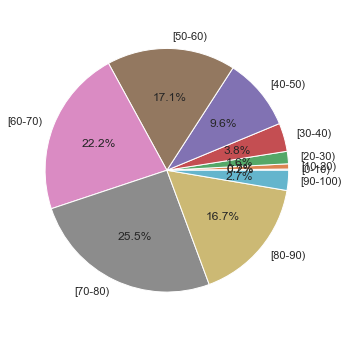

In [24]:
age_d = pd.DataFrame(df_clean.groupby(['age']).size(), columns = ['count'])
fig_dims = (5, 5)
fig, ax = plt.subplots(figsize=fig_dims)

ax.pie(age_d, labels = age_d.index, autopct='%1.1f%%')
ax.axis('equal')
plt.tight_layout()
#sns.barplot(data = cer, x = 'age',y='%readmission', ax = ax, order = cer['age'])

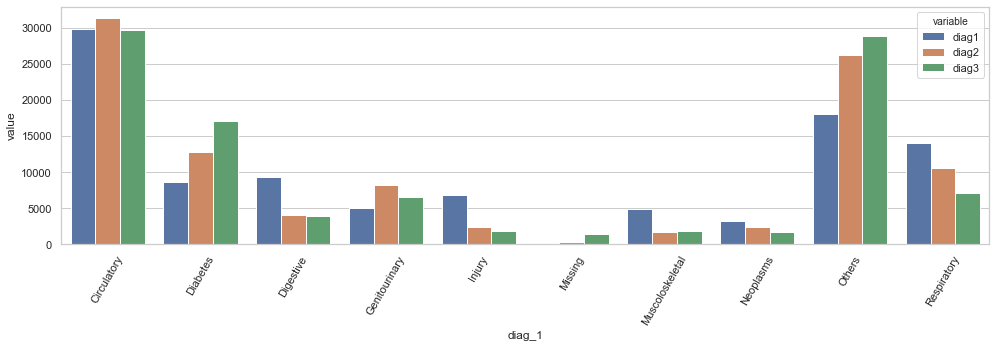

In [25]:
cer1 = pd.DataFrame(df_clean.groupby(['diag_1']).size(), columns = ['diag1'])#plot(kind='bar', stacked = True)
cer2 = dict(df_clean.groupby(['diag_2']).size(), columns = ['d2'])
cer3 = dict(df_clean.groupby(['diag_3']).size(), columns = ['d3'])


cer1 = cer1.rename(columns=str).reset_index()#drop('readmitted',axis = 1)

cer1['diag2'] = cer1.diag_1.map(cer2)
cer1['diag3'] = cer1.diag_1.map(cer3)
cer1 = pd.melt(cer1, id_vars = ['diag_1'],value_vars = ['diag1','diag2','diag3']).reset_index()

fig_dims = (14, 5)
fig, ax = plt.subplots(figsize=fig_dims)

chart = sns.barplot(data = cer1, x = 'diag_1',y='value', hue = 'variable' )
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.tight_layout()

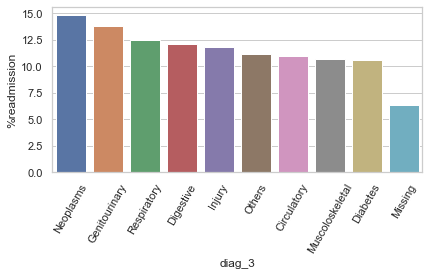

In [26]:
diag = df_clean.groupby(['diag_3', 'readmitted']).size().unstack()#plot(kind='bar', stacked = True)

#diag.reset_index()

diag = diag.rename(columns=str).reset_index()#drop('readmitted',axis = 1)

diag['total'] = diag['<30']+diag['>30']+diag['NO']
diag['% total'] = 100* (diag['total']/(diag['total'].sum()))
diag['%readmission'] = 100* (diag['<30']/diag['total'])
diag.sort_values('%readmission',ascending = False, inplace = True)

#fig_dims = (10, 5)
#fig, ax = plt.subplots(figsize=fig_dims)

#ax.pie(diag, labels = diag.index, autopct='%1.1f%%')
#ax.axis('equal')

chart = sns.barplot(data = diag, x = 'diag_3',order = diag.diag_3,y='%readmission')
chart.set_xticklabels(chart.get_xticklabels(), rotation=60) 
plt.tight_layout()

In [ ]:
#cer = df_clean.groupby(['diag_1', 'age']).size().unstack().T#plot(kind='bar', stacked = True)

#cer.reset_index()
#cat = list(df_clean.age.unique())

#cer = cer.rename(columns=str).reset_index()#drop('readmitted',axis = 1)
#cer = pd.melt(cer, id_vars = ['diag_1'],value_vars = cat).reset_index(drop = True)
#cer
#cer.plot(kind = 'bar', stacked = True)

#cer['total'] = cer['<30']+cer['>30']+cer['NO']
#cer['% total'] = 100* (cer['total']/(cer['total'].sum()))
#cer['%readmission'] = 100* (cer['<30']/cer['total'])
#cer.sort_values('%readmission',ascending = False, inplace = True)

fig_dims = (12, 10)
fig, ax = plt.subplots(nrows = 4, ncols = 2,figsize=fig_dims)

#ax.pie(cer, labels = cer.index, autopct='%1.1f%%')
#ax.axis('equal')

#sns.catplot(x="time_in_hospital", kind="count", data=df_clean, ax=ax[0][0])
sns.distplot(df_clean.time_in_hospital,ax=ax[0][0])
sns.distplot(df_clean.num_lab_procedures,ax=ax[0][1])
sns.distplot(df_clean.num_procedures,ax=ax[1][0])
sns.distplot(df_clean.num_medications,ax=ax[1][1])
#sns.catplot(x="number_outpatient", kind="count", data=df_clean, ax=ax[2][0], hue = df_clean.readmitted)
#sns.catplot(x="number_emergency", kind="count", data=df_clean, ax=ax[2][1])
#sns.catplot(x="number_inpatient", kind="count", data=df_clean, ax=ax[3][0])
sns.distplot(df_clean.number_diagnoses,ax=ax[3][1])
ax[2][0].hist(df_clean.number_outpatient)
ax[2][0].set_xlabel('Number Outpatient')

ax[2][1].hist(df_clean.number_emergency)
ax[2][1].set_xlabel('Number Emergency')

ax[3][0].hist(df_clean.number_inpatient)
ax[3][0].set_xlabel('Number Inpatient')
#sns.distplot(df_clean.number_outpatient,ax=ax[2][0], hist = False, hue = df_clean.readmitted)
#sns.distplot(df_clean.number_emergency,ax=ax[2][1])

#ax[2][0].set_xticklabels(rotation=60) 
ax[2][0].set_yscale('log')
ax[2][1].set_yscale('log')
ax[3][0].set_yscale('log')
#sns.distplot(df_clean.num_medications[df_clean.readmitted != '<30'],ax=ax[1][1])

#, kind="count", hue = 'readmitted',dodge=True, data=df_clean)

#fig.legend(loc='upper right')
#chart.set_xticklabels(rotation=60) 
fig.tight_layout()
#plt.show()

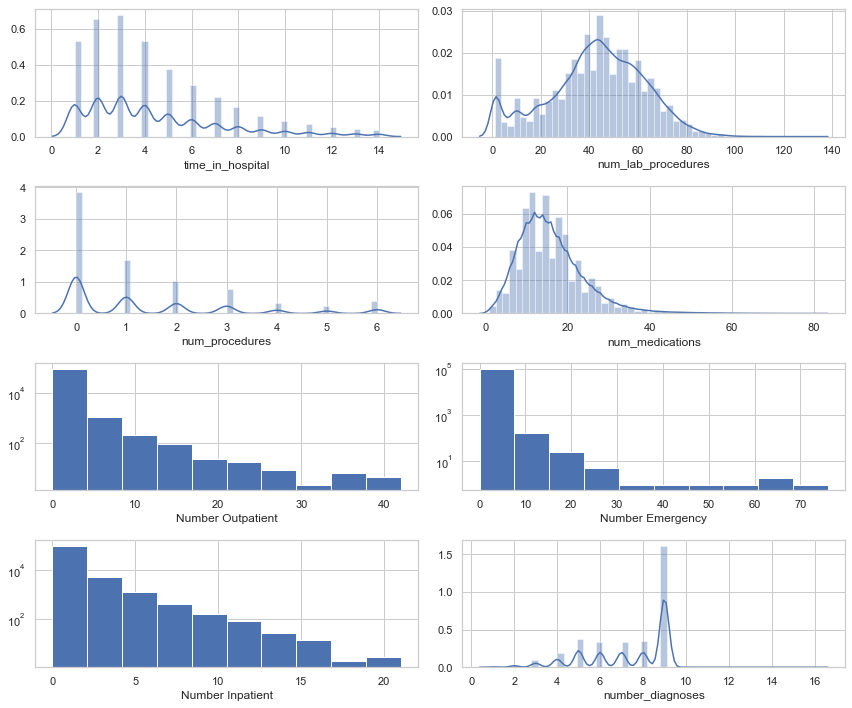

In [59]:
#cer = df_clean.groupby(['diag_1', 'age']).size().unstack().T#plot(kind='bar', stacked = True)

#cer.reset_index()
#cat = list(df_clean.age.unique())

#cer = cer.rename(columns=str).reset_index()#drop('readmitted',axis = 1)
#cer = pd.melt(cer, id_vars = ['diag_1'],value_vars = cat).reset_index(drop = True)
#cer
#cer.plot(kind = 'bar', stacked = True)

#cer['total'] = cer['<30']+cer['>30']+cer['NO']
#cer['% total'] = 100* (cer['total']/(cer['total'].sum()))
#cer['%readmission'] = 100* (cer['<30']/cer['total'])
#cer.sort_values('%readmission',ascending = False, inplace = True)

fig_dims = (12, 10)
fig, ax = plt.subplots(nrows = 4, ncols = 2,figsize=fig_dims)

#ax.pie(cer, labels = cer.index, autopct='%1.1f%%')
#ax.axis('equal')

#sns.catplot(x="time_in_hospital", kind="count", data=df_clean, ax=ax[0][0])
sns.distplot(df_clean.time_in_hospital,ax=ax[0][0])
sns.distplot(df_clean.num_lab_procedures,ax=ax[0][1])
sns.distplot(df_clean.num_procedures,ax=ax[1][0])
sns.distplot(df_clean.num_medications,ax=ax[1][1])
#sns.catplot(x="number_outpatient", kind="count", data=df_clean, ax=ax[2][0], hue = df_clean.readmitted)
#sns.catplot(x="number_emergency", kind="count", data=df_clean, ax=ax[2][1])
#sns.catplot(x="number_inpatient", kind="count", data=df_clean, ax=ax[3][0])
sns.distplot(df_clean.number_diagnoses,ax=ax[3][1])
ax[2][0].hist(df_clean.number_outpatient)
ax[2][0].set_xlabel('Number Outpatient')

ax[2][1].hist(df_clean.number_emergency)
ax[2][1].set_xlabel('Number Emergency')

ax[3][0].hist(df_clean.number_inpatient)
ax[3][0].set_xlabel('Number Inpatient')
#sns.distplot(df_clean.number_outpatient,ax=ax[2][0], hist = False, hue = df_clean.readmitted)
#sns.distplot(df_clean.number_emergency,ax=ax[2][1])

#ax[2][0].set_xticklabels(rotation=60) 
ax[2][0].set_yscale('log')
ax[2][1].set_yscale('log')
ax[3][0].set_yscale('log')
#sns.distplot(df_clean.num_medications[df_clean.readmitted != '<30'],ax=ax[1][1])

#, kind="count", hue = 'readmitted',dodge=True, data=df_clean)

#fig.legend(loc='upper right')
#chart.set_xticklabels(rotation=60) 
fig.tight_layout()
#plt.show()


In [ ]:
sns.pairplot(data=df_clean[int_names],vars = ['time_in_hospital','visit_num'])

In [153]:
cer

readmitted,diag_1,<30,>30,NO,total,% total,%readmission
5,Missing,5,4,11,20,0.019978,25.000000
1,Diabetes,1137,3318,4238,8693,8.683448,13.079489
4,Injury,854,2237,3788,6879,6.871441,12.414595
0,Circulatory,3477,10802,15504,29783,29.750275,11.674445
8,Others,2094,6301,9589,17984,17.964239,11.643683
3,Genitourinary,555,1716,2783,5054,5.048447,10.981401
2,Digestive,1015,3364,5001,9380,9.369693,10.820896
7,Neoplasms,346,800,2153,3299,3.295375,10.488027
9,Respiratory,1403,5532,7139,14074,14.058536,9.968737
6,Muscoloskeletal,471,1471,3002,4944,4.938568,9.526699


In [ ]:
%%time
int_names = list(df_clean.select_dtypes(include='int64').columns)
int_names.extend(['readmitted'])
sns.pairplot(data=df_clean[int_names],vars = ['time_in_hospital','visit_num'])

In [69]:
`x = df1[['medical_specialty','diag_1','diag_2','diag_3']]
x[x['medical_specialty'] == 'Pediatrics-Endocrinology'].head()
type(x.diag_1[0])

str

In [81]:
fatal = df1[df1['Accident_Severity']=='Fatal']
cer2 = fatal.groupby(['Road_Surface_Conditions']).resample('Y').count()['Accident_Severity'].unstack().transpose()
cer2.head()
Slight = df1[df1['Accident_Severity']=='Slight']
cer3 = Slight.groupby(['Road_Surface_Conditions']).resample('Y').count()['Accident_Severity'].unstack().transpose()
cer3.head()
Serious = df1[df1['Accident_Severity']=='Serious']
cer4 = Serious.groupby(['Road_Surface_Conditions']).resample('Y').count()['Accident_Severity'].unstack().transpose()
cer4.head()

Road_Surface_Conditions,Dry,Flood over 3cm. deep,Frost or ice,Snow,Wet or damp
Date,,,,,
2005-12-31,17340,29,380,114,7141
2006-12-31,17250,21,273,49,7330
2007-12-31,17181,54,284,51,6734
2008-12-31,15733,45,463,71,6776
2009-12-31,15318,33,557,180,5902


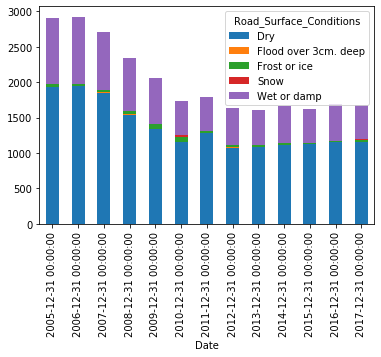

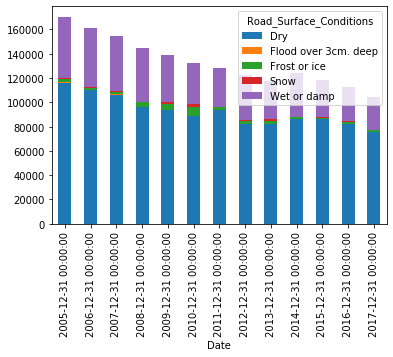

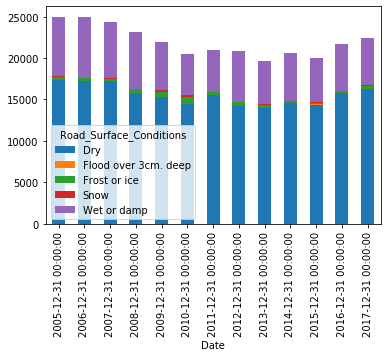

In [80]:
cer2.plot(kind = 'bar', stacked = True)
cer3.plot(kind = 'bar', stacked = True)
cer4.plot(kind = 'bar', stacked = True)

In [ ]:
#nums = Counter()
#for i in range(0,l-1):
#    nums.update(df_clean.patient_nbr[:i+1])
 #   df_clean['visit_num'].iloc[i] = nums[df_clean.patient_nbr[i]]